## Initial setup

In [122]:
import pandas as pd
import numpy as np

train_meta = pd.read_csv("./train/train_metadata.csv")
train_add_features = pd.read_csv("./train/features/additional_features.csv")
train_color_hist = pd.read_csv("./train/features/color_histogram.csv")
train_hog_pca = pd.read_csv("./train/features/hog_pca.csv")


test_meta = pd.read_csv("./test/test_metadata.csv")
test_meta.drop("ClassId", inplace=True, axis=1) # useless for now
test_add_features = pd.read_csv("./test/features/additional_features.csv")
test_color_hist = pd.read_csv("./test/features/color_histogram.csv")
test_hog_pca = pd.read_csv("./test/features/hog_pca.csv")

In [ ]:
# merging all the dataframes

train_df = pd.merge(train_meta, train_add_features)
train_df = pd.merge(train_df, train_color_hist)
train_df = pd.merge(train_df, train_hog_pca)

test_df = pd.merge(test_meta, test_add_features)
test_df = pd.merge(test_df, test_color_hist)
test_df = pd.merge(test_df, test_hog_pca)


# this is just better for reading files
train_df["image_path"] = train_df["image_path"].apply(lambda x : "train/" + x)
test_df["image_path"] = test_df["image_path"].apply(lambda x : "test/" + x)

# Initial Exploration

In [124]:
# Each class is represented at least once in the test data
set(train_df["ClassId"].unique()).difference(set(range(0, 43)))


set()

Text(0, 0.5, 'Frequency')

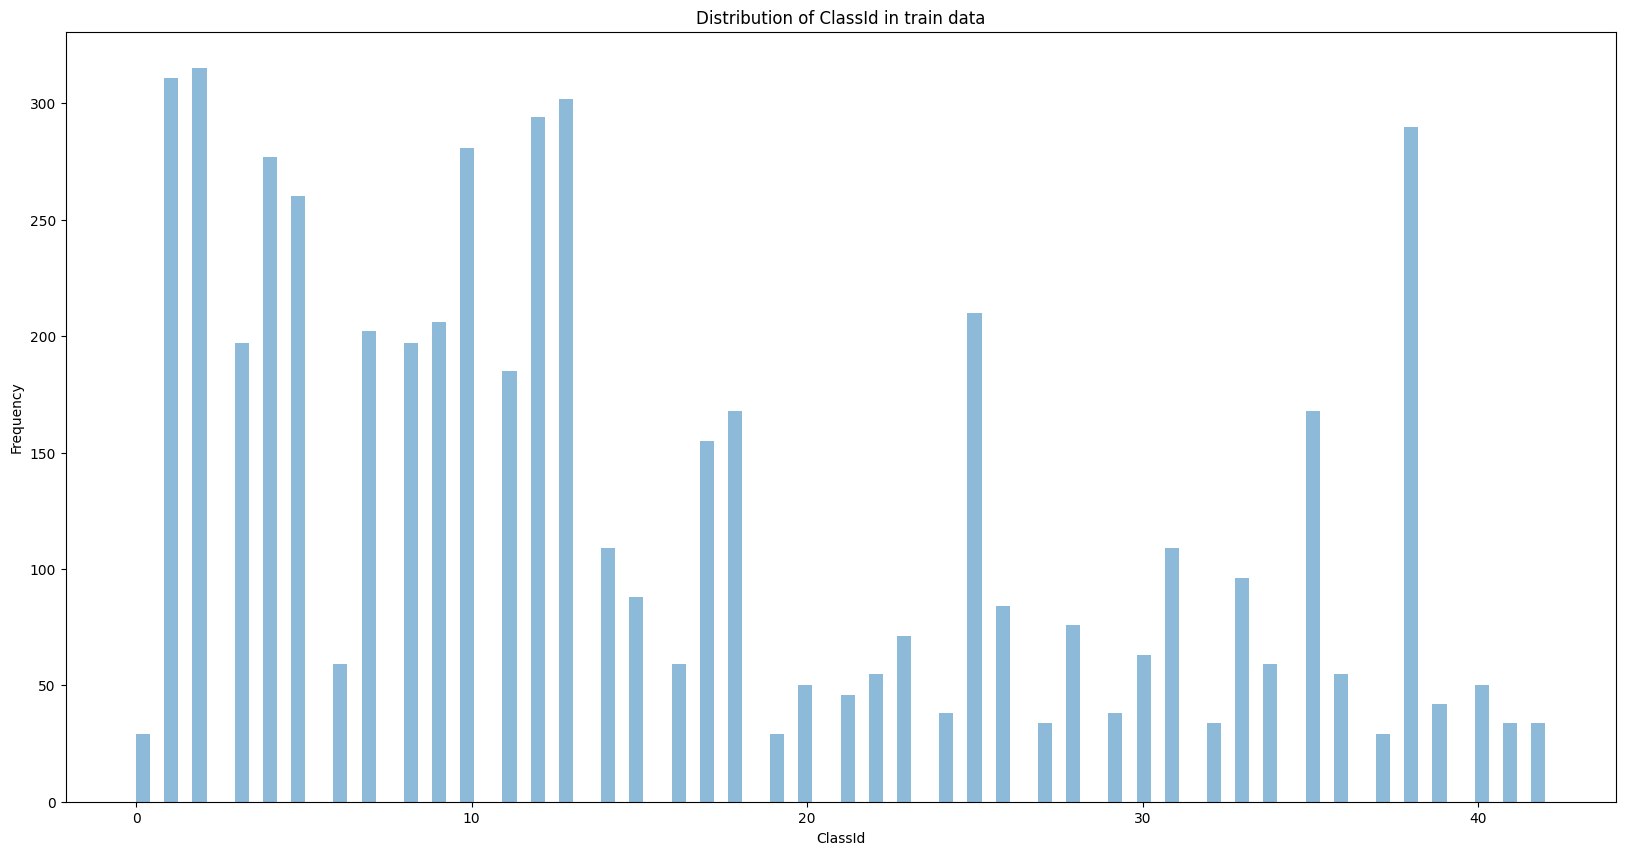

In [125]:
import matplotlib.pyplot as plt
# lets look at the distribution of the test data:

plt.figure(figsize=(20, 10))
plt.hist(train_meta['ClassId'], bins=100, alpha=0.5, label='train')
plt.title('Distribution of ClassId in train data')
plt.xlabel('ClassId')
plt.ylabel('Frequency')

# Additional Feature extraction

## Edge Density

In [ ]:
from scipy import ndimage
import numpy as np
import matplotlib.image as mpimg
# extracting the edge density of each of the images
# this is different from the information we get from the hog pca
# hog gives us the orientation of pixels but edge density gives us the "busyness"
# of the edges of the image, this seems useful for sign stuff

def get_ed(img_path):
    img = mpimg.imread(img_path)

    gx = ndimage.sobel(img, axis=1)               
    gy = ndimage.sobel(img, axis=0)               
    mag = np.hypot(gx, gy)
    edge_density = np.mean(mag > mag.mean())      

    return edge_density

# [get_ed(pth) for pth in train_df["image_path"]]
train_df["ed"] = train_df["image_path"].apply(get_ed)
test_df["ed"] = test_df["image_path"].apply(get_ed)

## Colour variance and skew

In [177]:
# get the colour variance and skew per channel
# this is missing from the original features, they have means but not the other moments for colours
def get_color_stats(img_path):
    img = mpimg.imread(img_path)
    r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]

    r_var, g_var, b_var = np.var(r), np.var(g), np.var(b)
    r_skew, g_skew, b_skew = pd.Series(r.flatten()).skew(), pd.Series(g.flatten()).skew(), pd.Series(b.flatten()).skew()

    return r_var, g_var, b_var, r_skew, g_skew, b_skew

dfs = [train_df, test_df]
for df in dfs:
    for row in df.iterrows():
        r_var, g_var, b_var, r_skew, g_skew, b_skew = get_color_stats(row[1]["image_path"])
        df.at[row[0], "r_var"] = r_var
        df.at[row[0], "g_var"] = g_var
        df.at[row[0], "b_var"] = b_var
        df.at[row[0], "r_skew"] = r_skew
        df.at[row[0], "g_skew"] = g_skew
        df.at[row[0], "b_skew"] = b_skew

## Wavelet Energy (CWT)

In [ ]:
from scipy.signal import cwt, ricker

# Flatten rows into 1D signal or apply patch‐wise
widths = np.arange(1, 31)
coeffs = cwt(img.mean(axis=0), ricker, widths)
wavelet_energy = np.mean(np.abs(coeffs))

In [127]:
from sklearn.model_selection import train_test_split
# train val test split

X_train, X_val, y_train, y_val = train_test_split(
    train_df.drop("ClassId", axis=1),
    train_df["ClassId"],
    test_size=0.1,
    random_state=42,
)